## Independent genomewide screens identify the tumor suppressor VTRNA2-1 as a human epiallele responsive to periconceptional environment

#### Download data from SRA

The Gene Expression Omnibus (GEO) accession number for the raw sequence reads for the four Bisulfite-seq libraries is GSE44806.

## 1. Bisulfite Sequence Mapping

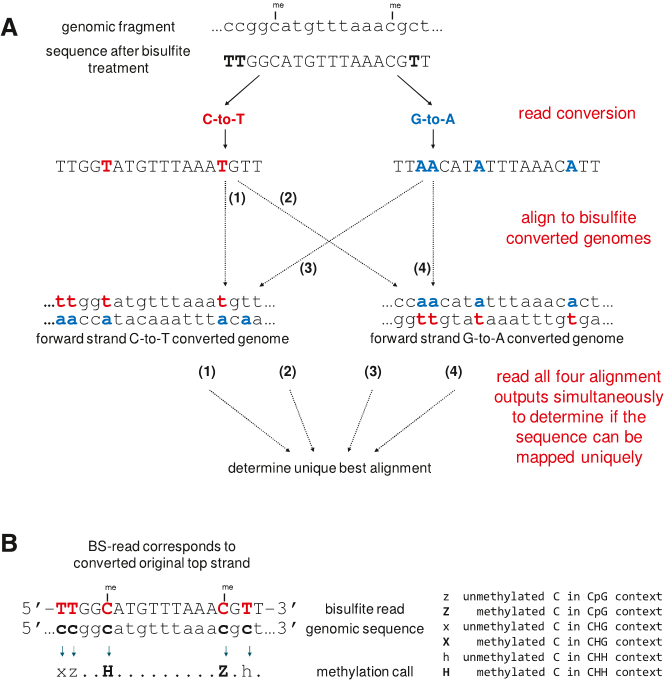

In [1]:
from IPython.display import Image
url = 'https://ai2-s2-public.s3.amazonaws.com/figures/2016-11-08/a114acb9c90d29d9611674824b01a007b6b7a115/1-Figure1-1.png'
Image(url,width=800, height=600)

In [28]:
from operator import add
import pandas as pd
import numpy as np
import os
import sys
from collections import defaultdict
filename = "../data/VTRNA2-1/create_plots/C01_HF_1_chr19.bismark.cov"
bin_size = 200

In [29]:
df_cov = pd.read_table(filename,header=None)

In [30]:
df_cov.columns = ['Chromosome','Position','End','Perc','Methylated','Unmethylated']

In [31]:
df_cov = df_cov.iloc[:,-6:]

In [36]:
df_cov = df_cov.sort_values(['Chromosome', 'Position'], ascending=[True, True])

In [37]:
df_cov = df_cov.reset_index(drop=True)

In [60]:
bin_coverage = defaultdict(lambda:0)
bin_data = defaultdict(lambda:[0,0]) # Mapping from bin number to a tuple consisting of #methylated reads and #unmethy. reads

### Detailed description of coverage file
--Chromosome-- --start_position-- --end_position-- --methylation_percentage-- --count_methylated-- --count_unmethylated--

The first line of the coverage file looks like follows;


In [55]:
print (df_cov.iloc[0:10])

  Chromosome  Position    End        Perc  Methylated  Unmethylated
0      chr19     61198  61198  100.000000           3             0
1      chr19     61291  61291  100.000000           8             0
2      chr19     61380  61380   66.666667           2             1
3      chr19     61396  61396  100.000000           3             0
4      chr19     61496  61496  100.000000           1             0
5      chr19     61835  61835    0.000000           0             1
6      chr19     61842  61842    0.000000           0             1
7      chr19     61861  61861    0.000000           0             1
8      chr19     62198  62198  100.000000           1             0
9      chr19     62748  62748    0.000000           0             1


### Position
The Position indicate the start location of the methylated citosine base (CG) in chromose-wise (by default). There is an option in methylation extractor to specify otherwise. (Check if this is correct ?)

### End
The end position of the citosine base. Its the same as the start because its one base.

### Methylation Percentage
This percentage represent the actual read coverage of detected methylated or unmethylated reads at a position.


### count methylated
out of the aligned reads, how many reads say its methylated CG

### count unmethylated
out of the aligned reads, how many reads says its unmethylated CG


In [56]:
line = df_cov.iloc[0]

In [57]:
# How to create the first bin
chrm_name = str(line["Chromosome"])
start = int(line["Position"])
end = int(line["End"])
num_methylated_reads = line["Methylated"]
num_unmethylated_reads = line["Unmethylated"]

In [58]:
bin_number = (start-1)//bin_size # Using integer division is the key here
print (bin_number)

305


In [59]:
bin_label = (bin_number*bin_size) + bin_size
print (bin_label)

61200


This creates the first bin

In [45]:
bin_data[bin_label] = list(map(add, bin_data[bin_label], [num_methylated_reads,num_unmethylated_reads]))
bin_coverage[bin_label] += 1

In [53]:
bin_data.items()

dict_items([(61200, [3, 0])])

In [54]:
bin_coverage.items()

dict_items([(61200, 1)])

read the next line from the cov file
    if CG belongs to the first bin 
        then add to that bin. 
    else 
        create the next bin.
        
 Do this for all lines in the coverage file.

In [61]:
for index, line in df_cov.iterrows():
    # Split line into components
    chrm_name = str(line["Chromosome"])
    start = int(line["Position"])
    end = int(line["End"])

    num_methylated_reads = line["Methylated"]
    num_unmethylated_reads = line["Unmethylated"]

    bin_number = (start-1)//bin_size # Using integer division is the key here
    bin_label = (bin_number*bin_size) + bin_size

    bin_data[bin_label] = list(map(add, bin_data[bin_label], [num_methylated_reads,num_unmethylated_reads]))
    bin_coverage[bin_label] += 1

In [73]:
i=0
for k,v in bin_data.items():
    i=i+1
    if (i == 6):
        break
    print ("%s - %s" % (str(k), str(v)))

61200 - [3, 0]
61400 - [13, 1]
61600 - [1, 0]
62000 - [0, 3]
62200 - [1, 0]


In [72]:
i=0
for k,v in bin_coverage.items():
    i=i+1
    if (i == 6):
        break
    print ("%s - %s" % (str(k), str(v)))

61200 - 1
61400 - 3
61600 - 1
62000 - 3
62200 - 1


In [74]:
coords = []
bin_names = []
methylations = []
cpgs_covered = []

# Append bin data do lists so we can add them to the data frame
sorted_keys = list(bin_data.keys())
sorted_keys.sort()


For each bin, calculate the coordinte for USCS GBrowser and percentage of average methylation.

In [85]:
#for _bin in sorted_keys:
# Caclucate Coordinates
_bin = sorted_keys[0]
bin_name = chrm_name + "_" + str(_bin)
bin_start_loc = _bin - bin_size
bin_end_loc = _bin
UCSC_browser_coordinates = chrm_name + ":" + str(bin_start_loc) + "-" +  str(bin_end_loc)

print(bin_name,bin_start_loc,bin_end_loc,UCSC_browser_coordinates)


chr19_61200 61000 61200 chr19:61000-61200


In [86]:
# Calculate Methylation percentage
bin_methylation_data = bin_data[_bin]
print(bin_methylation_data)
avg_methylation = 0
if bin_methylation_data[0]+bin_methylation_data[1] != 0: # Denominator is not 0
    avg_methylation  = 100.0*bin_methylation_data[0]/(bin_methylation_data[0]+bin_methylation_data[1])
print(avg_methylation)

[3, 0]
100.0


In [87]:
bin_coverage[_bin]

1

Now, lets do this for all bins.

In [89]:

sorted_keys = list(bin_data.keys())
sorted_keys.sort()
for _bin in sorted_keys:

    # Coordinates
    bin_name = chrm_name + "_" + str(_bin)
    bin_start_loc = _bin - bin_size
    bin_end_loc = _bin
    UCSC_browser_coordinates = chrm_name + ":" + str(bin_start_loc) + "-" +  str(bin_end_loc)

    # Methylation percentage
    bin_methylation_data = bin_data[_bin]
    avg_methylation = 0
    if bin_methylation_data[0]+bin_methylation_data[1] != 0: # Denominator is not 0
        avg_methylation  = 100.0*bin_methylation_data[0]/(bin_methylation_data[0]+bin_methylation_data[1])

    # Append data to lists
    coords.append(UCSC_browser_coordinates)
    bin_names.append(bin_name)
    methylations.append(avg_methylation)
    cpgs_covered.append(bin_coverage[_bin])


In [90]:
dataframe_data = {"UCSC Browser Coordinates":coords,"Bin Name":bin_names,"Avg Methylation":methylations,"CpGs Covered":cpgs_covered}
df = pd.DataFrame.from_dict(dataframe_data)
rearranged_cols = ["UCSC Browser Coordinates","Bin Name","Avg Methylation","CpGs Covered"]
df = df.reindex_axis(rearranged_cols, axis=1)

In [93]:
df.iloc[0:10]

,UCSC Browser Coordinates,Bin Name,Avg Methylation,CpGs Covered
0,chr19:61000-61200,chr19_61200,100.000000,1
1,chr19:61200-61400,chr19_61400,92.857143,3
2,chr19:61400-61600,chr19_61600,100.000000,1
3,chr19:61800-62000,chr19_62000,0.000000,3
4,chr19:62000-62200,chr19_62200,100.000000,1
5,chr19:62600-62800,chr19_62800,0.000000,1
6,chr19:62800-63000,chr19_63000,81.818182,5
7,chr19:63000-63200,chr19_63200,85.294118,3
8,chr19:63200-63400,chr19_63400,80.000000,5
9,chr19:63400-63600,chr19_63600,100.000000,1


In [94]:

df_jack = pd.read_csv("../data/VTRNA2-1/c01-hf/C01_HF_chr19_lane1_bins_Jack.csv")

In [96]:
df_jack.iloc[0:10]

,UCSC Browser Coordinates,Bin Name,Avg Methylation,CpGs Covered
0,chr19:61000-61200,chr19_61200,100.000000,1
1,chr19:61200-61400,chr19_61400,92.857143,3
2,chr19:61400-61600,chr19_61600,100.000000,1
3,chr19:61800-62000,chr19_62000,0.000000,3
4,chr19:62000-62200,chr19_62200,100.000000,1
5,chr19:62600-62800,chr19_62800,0.000000,1
6,chr19:62800-63000,chr19_63000,81.818182,5
7,chr19:63000-63200,chr19_63200,85.294118,3
8,chr19:63200-63400,chr19_63400,80.000000,5
9,chr19:63400-63600,chr19_63600,100.000000,1
